In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D


%matplotlib inline

In [ ]:
HOUSE_DATASET = []
HOUSE_DATASET_BIN = []
DOUBLE_HOUSES = []
DOUBLE_MOVE_HOUSES = []

house_combined = np.load('combined.npy')
blocks = []
for h in house_combined:
    # houses look rotated... just rotate them back
    h = np.rot90(h,axes=(0,2))
    
    # remove bottom layer (got the ground as well) - i can't believe i got it right on the first try...
    h = h[3:, 3:, 1:-2]
    HOUSE_DATASET.append(h)
    
    #binary
    idx = np.nonzero(h)
    hb = np.zeros(shape=h.shape)
    for i in range(len(idx[0])):
        a,b,c = idx
        hb[a[i]][b[i]][c[i]] = 1
    HOUSE_DATASET_BIN.append(hb)

    #doubled binary
    h2 = hb
    dh = np.zeros(shape=(32,32,32))
    m = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)]
    for x in range(16):
        for y in range(16):
            for z in range(16):
                v = h2[x][y][z]
                if v == 0:
                    continue
                for mi in m:
                    dh[x*2+mi[0]][y*2+mi[1]][z*2+mi[2]] = v
    DOUBLE_HOUSES.append(dh)

    #doubled binary and rotated
    hi = np.copy(dh)
    DOUBLE_MOVE_HOUSES.append(hi)
    DOUBLE_MOVE_HOUSES.append(np.rot90(hi,axes=(0,1)))
    DOUBLE_MOVE_HOUSES.append(np.rot90(hi,axes=(1,0)))
    DOUBLE_MOVE_HOUSES.append(np.rot90(np.rot90(hi,axes=(1,0)),axes=(1,0)))
    
        
HOUSE_DATASET = np.array(HOUSE_DATASET)
HOUSE_DATASET_BIN = np.array(HOUSE_DATASET_BIN)
DOUBLE_HOUSES = np.array(DOUBLE_HOUSES)
DOUBLE_MOVE_HOUSES = np.array(DOUBLE_MOVE_HOUSES)

In [ ]:
def show3D(builds, binary=True, textArr=None):
    fig = plt.figure(figsize=(20,7))
    col = 8
    
    if binary:
        colors = 'red'
    else:
        colors = 'red' #replace later with colors for each block id value [0-12]
    
    for i, build in enumerate(builds):
        ax = fig.add_subplot(int(len(builds) / col) + 1, col, i + 1,  projection='3d')
        ax.voxels(build, edgecolor="k", facecolors=colors, linewidth=0.5)
        plt.axis('off')
        if textArr != None:
            plt.title(textArr[i])
    plt.show()

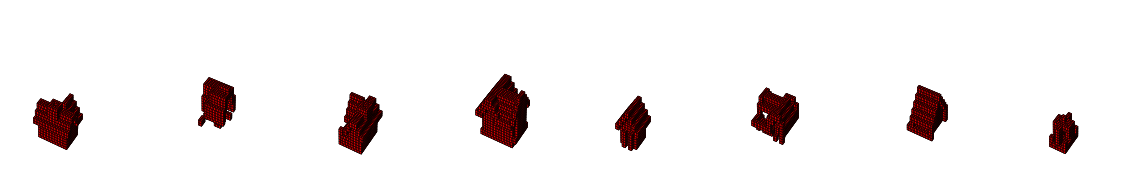

In [ ]:
# show a few random ones to verify
show3D(DOUBLE_MOVE_HOUSES[random.choices(list(range(len(HOUSE_DATASET_BIN))),k=8)])

### AE Implementation (taken from https://github.com/kdj842969/3D-Autoencoder)

In [ ]:
class Mini_AE(Model):
    def __init__(self,batches=16):
        super(Mini_AE, self).__init__()
        
        self.batch_size = batches
        
        #make the models
        self.makeModel()
        
    def makeModel(self):
        input_img = Input(shape=(32, 32, 32, 1))
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(input_img)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(x)
        encoded = MaxPooling3D((2, 2, 2), padding='same')(x)
        
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(encoded)
        x = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
        decoded = Conv3D(1, (5, 5, 5), activation='relu', padding='same')(x)
        
        self.autoencoder = Model(input_img, decoded)
        
    def train(self,train_dat,EPOCHS=200):
        
        self.autoencoder.summary()
        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')   #DO NOT CHANGE FROM ADAM! BEST RESULTS!
        self.autoencoder.fit(train_dat,train_dat,epochs=EPOCHS,batch_size=self.batch_size)

In [ ]:
#train buddy!
voxel_ae = Mini_AE()

with tf.device('/device:GPU:0'):
  voxel_ae.train(DOUBLE_MOVE_HOUSES,200)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d_52 (Conv3D)          (None, 32, 32, 32, 30)    3780      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 16, 16, 16, 30)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 16, 16, 16, 60)    225060    
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 8, 8, 8, 60)      0         
 g3D)                                                            
                                                                 
 conv3d_54 (Conv3D)          (None, 8, 8, 8, 60)       450

RECON


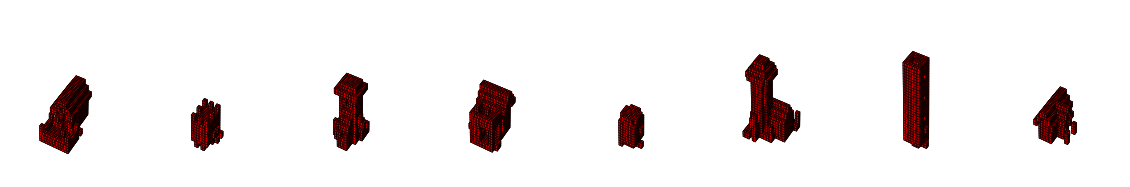

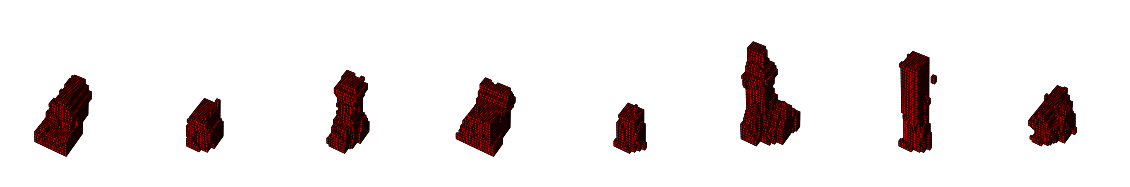

In [ ]:
def reconAETest(ae_model,testData):
    # get prediction output
    decoded_imgs = ae_model.autoencoder.predict(testData).squeeze()
    
    # show the two outputs on top of each other
#     testData2 = np.copy(testData)
#     testData2[testData2<0] = 0
#     testData2[testData2>0] = 1
    
#     decoded_imgs[decoded_imgs<0] = 0
#     decoded_imgs[decoded_imgs>0] = 1
    
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
print("RECON")
rand_index = random.choices(list(range(len(DOUBLE_HOUSES))),k=8)
RAND_SEL = DOUBLE_HOUSES[rand_index]
reconAETest(voxel_ae,RAND_SEL)

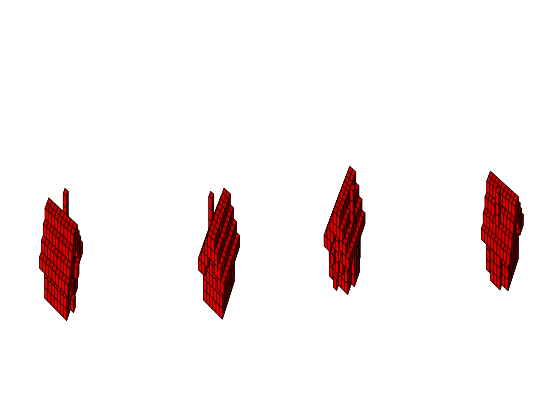

In [ ]:
hi = HOUSE_DATASET_BIN[0]
MOVE_HOUSES = [hi]
MOVE_HOUSES.append(np.rot90(hi,axes=(0,1)))
MOVE_HOUSES.append(np.rot90(hi,axes=(1,0)))
MOVE_HOUSES.append(np.rot90(np.rot90(hi,axes=(1,0)),axes=(1,0)))
show3D(MOVE_HOUSES)

### VAE Reimplementation


In [ ]:
from IPython.lib.display import YouTubeVideo
from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon
    

class VAE(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 32
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()
        
    #makes the encoder model for the VAE
    def makeEncoder(self):
        
        #variational encoder
        # enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        # x = Conv3D(16, kernel_size=5, padding='same', activation='relu')(enc_in)
        # x = MaxPooling3D((2, 2, 2), padding='same')(x)
        # x = Conv3D(32, kernel_size=5, padding='same', activation='relu')(x)
        # x = MaxPooling3D((2, 2, 2), padding='same')(x)
        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(enc_in)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(x)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Flatten()(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        y = Dense(30720, activation="relu")(dec_in)  #product of output shape of autoencoder
        y = Reshape((8,8,8,60))(y)  #output shape of autoencoder
        
        
        # y = Conv3D(32, kernel_size=5, activation='relu', padding='same')(y)
        # y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        # y = Conv3D(16, kernel_size=5, activation='relu', padding='same')(y)
        # y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        # dec_out = Conv3D(1, kernel_size=5, activation='relu', padding='same')(y)

        y = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        y = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(y)
        y = tf.keras.layers.UpSampling3D((2, 2, 2))(y)
        dec_out = Conv3D(1, (5, 5, 5), activation='relu', padding='same')(y)    

        self.decoder = Model(dec_in, dec_out)

        
        if DEBUG:
            self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
#         return K.mean(K.square(tf.cast(y_true,tf.float32) - tf.cast(y_pred,tf.float32)), axis = [1,2,3])
        return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2,3)))
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
#         return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1)))
        return kl_loss
    
    #singular step for training
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl = self.kl_loss(z_log_var,z_mean)
#             tl = 10000*reconstruction_loss+kl
            tl = reconstruction_loss+kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}

In [ ]:
# VAE TEST

#setup
EPOCHS = 200   #training longer gets better reconstruction
BATCH_SIZE = 16
Z_SIZE = 100
CHANNELS = 1

INPUT_DATA = DOUBLE_MOVE_HOUSES

DEBUG = True
    

#create batch data
train_dat = tf.data.Dataset.from_tensor_slices(INPUT_DATA).shuffle(len(INPUT_DATA)).batch(BATCH_SIZE)

# create the VAE
HOUSE_VAE = VAE(Z_SIZE,BATCH_SIZE,CHANNELS)
HOUSE_VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# train the VAE
with tf.device('/device:GPU:0'):
  history = HOUSE_VAE.fit(np.expand_dims(DOUBLE_MOVE_HOUSES,axis=-1),epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_81 (Conv3D)             (None, 32, 32, 32,   3780        ['input_28[0][0]']               
                                30)                                                               
                                                                                                  
 max_pooling3d_35 (MaxPooling3D  (None, 16, 16, 16,   0          ['conv3d_81[0][0]']              
 )                              30)                                                         

In [ ]:
# show reconstruction from the VAE
def reconVAETest(vae_model,testData):
    # get prediction output
    encoded_imgs = vae_model.encoder.predict(testData)
    decoded_imgs = np.around(vae_model.decoder.predict(encoded_imgs[2]).squeeze())
    
    # show the two outputs on top of each other
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
# generate and show new sample from the VAE
def generateVAESamples(vae_model,n=8,zsize=20):
    vae_samples = np.around(vae_model.decoder.predict(np.random.normal(0,1,size=(n,zsize))).squeeze())
    show3D(vae_samples)

RECON


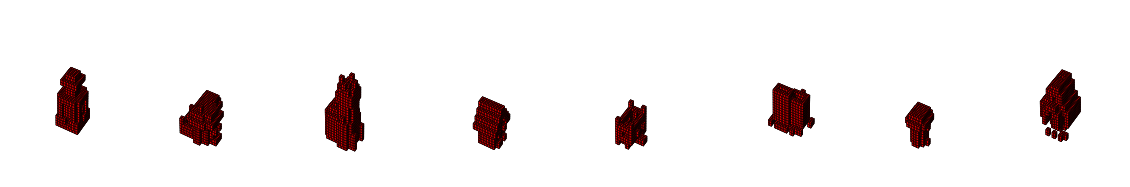

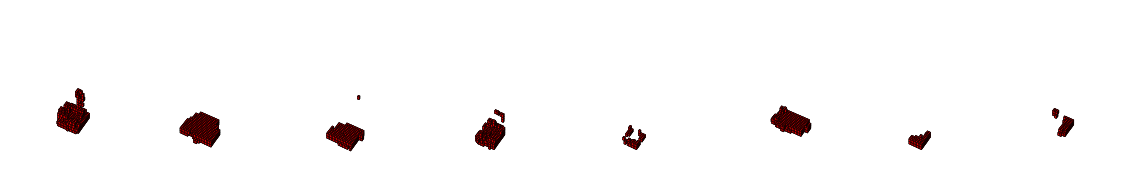

SAMPLE


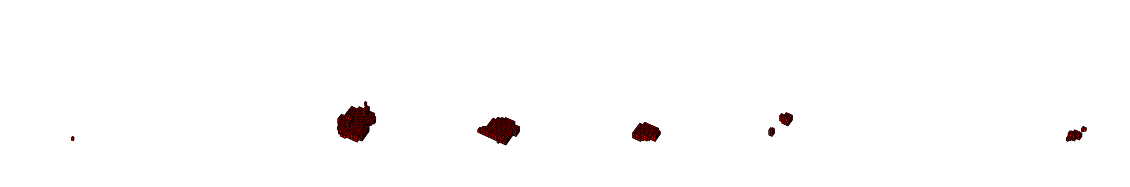

In [ ]:
print("RECON")
rand_index = random.choices(list(range(len(INPUT_DATA))),k=8)
RAND_SEL = INPUT_DATA[rand_index]
reconVAETest(HOUSE_VAE,RAND_SEL)

print("SAMPLE")
generateVAESamples(HOUSE_VAE,zsize=Z_SIZE)

In [ ]:
len(DOUBLE_MOVE_HOUSES)

576